In [1]:
import grafiti as gf
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import squidpy as sq
from sklearn import metrics
import umap as umap_ext
import pandas as pd
import pickle
import seaborn as sns
import torch
from scipy import stats
from statannot import add_stat_annotation


import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/osmfish"
figdir = "/data1/shahs3/users/mezallj1/figures/osmfish"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def umap(adata, encoding_key="X_grafiti",n_neighbors=20,max_iter=100, min_dist=0.5, metric="euclidean", scanpy=False, neighbors_key="grafiti_neighbors", embd_name="X_umap"):
    if not scanpy:
        ldm = umap_ext.UMAP(n_epochs=max_iter,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric)
        embd = ldm.fit_transform(adata.obsm[encoding_key])
        adata.obsm[embd_name] = embd
    else:
        sc.tl.umap(adata,neighbors_key=neighbors_key)

# 10 Iterations

In [3]:
def read_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
def plot_spatial(datadir, iteration):
    adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst_{iteration}.h5ad')
    adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate_{iteration}.h5ad')
    adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{iteration}_grafiti_lodcl_grid_100_100_0.0001_5_5_0.995.h5adf')

    adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 8))
    sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape=None, ax=axes[0], size=100)
    sq.pl.spatial_scatter(adata_graphst, title = 'GraphST: %.3f'%(graphst[iteration]), color ='mclust', shape=None, ax=axes[1], size=100)
    sq.pl.spatial_scatter(adata_stagate, title = 'STAGATE: %.3f'%(stagate[iteration]), color ='mclust', shape=None, ax=axes[2], size=100)
    sq.pl.spatial_scatter(adata_grafiti, title = 'Grafiti: %.3f'%(grafiti[iteration]), color ='grafiti_motif', shape=None, ax=axes[3], size=100)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_umap(datadir, iteration):
    adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst_{iteration}.h5ad')
    adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate_{iteration}.h5ad')
    adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{iteration}_grafiti_lodcl_grid_100_100_0.0001_5_5_0.995.h5adf')

    adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    umap(adata_graphst, encoding_key="emb")
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    sc.pl.umap(adata_graphst,title="GraphST",color=["mclust"],ax=axes[0],s=20,show=False)
    sc.pl.umap(adata_stagate,title="STAGATE",color=["mclust"],ax=axes[1],s=20,show=False)
    sc.pl.umap(adata_grafiti,title="Grafiti",color=["grafiti_motif"],ax=axes[2],s=20,show=False)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_boxplot(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 16))
    sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Method')
    plt.title('osmFISH (10 Iterations)')
    plt.show()

In [7]:
def plot_violinplot(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Method')
    plt.title('DLPFC (12 Slices)')
    plt.show()

In [8]:
def create_comparison_plot(list_dic, categories, indices, type, title, figsize, save=None):
    # Ensure inputs are of the same length
    if len(list_dic) != len(categories):
        raise ValueError('The size of both inputs should be the same')

    # Select only the specified indices
    list_dic = [list_dic[i] for i in indices]
    categories = [categories[i] for i in indices]

    # Create DataFrame from the first dictionary
    df = pd.DataFrame(list_dic[0][0].items(), columns=['Index', categories[0]])
    
    # Add subsequent dictionaries to the DataFrame
    for i in range(1, len(list_dic)):
        df = df.merge(pd.DataFrame(list_dic[i].items(), columns=['Index', categories[i]]), on='Index', how='outer')

    # Melt the DataFrame for seaborn
    df_melted = df.melt(id_vars='Index', var_name='Method', value_name='Score')

    # Extract unique methods for creating pairs
    unique_methods = df_melted['Method'].unique()

    # Create pairs only for methods present in the melted DataFrame
    pairs = [(unique_methods[i], unique_methods[j]) for i in range(len(unique_methods)) for j in range(i + 1, len(unique_methods))]

    # Create the plot
    plt.figure(figsize=figsize)
    if type == 'barplot':
        ax = sns.barplot(x='Method', y='Score', data=df_melted, ci='sd', palette='Set2', capsize=0.1, errcolor='black', errwidth=1.5)
    elif type == 'boxplot':
        ax = sns.boxplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    elif type == 'violinplot':
        ax = sns.violinplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    ax = sns.swarmplot(x='Method', y='Score', data=df_melted, color='.25', size=5)

    # Rotate y-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add statistical annotations using statannot
    add_stat_annotation(ax, data=df_melted, x='Method', y='Score',
                        box_pairs=pairs,
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2, comparisons_correction='bonferroni', 
                        line_height=0.02, linewidth=1.5, fontsize='medium')

    plt.xlabel('Method', fontsize=14)
    plt.ylabel('Adjusted Rand Index (ARI)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    if save != None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
stagate = read_pickle(f'{datadir}/stagate/ari_stagate_s.pkl')
graphst = read_pickle(f'{datadir}/graphst/ari_graphst_s.pkl')
grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_5_5_0.995.h5ad')
og_grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl'),

In [10]:
stagate

{1: 0.14926696206013118,
 2: 0.14926696206013118,
 3: 0.14926696206013118,
 4: 0.14926696206013118,
 5: 0.14926696206013118,
 6: 0.14926696206013118,
 7: 0.14926696206013118,
 8: 0.14926696206013118,
 9: 0.14926696206013118,
 10: 0.14926696206013118}

In [11]:
og_grafiti

({1: 0.17599866507035156,
  2: 0.18203664327154204,
  3: 0.12176163465766598,
  4: 0.18264421920615456,
  5: 0.0746453608805562,
  6: 0.03873918037823993,
  7: 0.09216581175011747,
  8: 0.003011747380731204,
  9: 0.22707245585764627,
  10: 0.11916843892172359},)

In [12]:
df = pd.DataFrame({
    'GraphST': graphst,
    'STAGATE': stagate,
    'Graffiti': grafiti
})

In [13]:
df

GraphST   STAGATE  Graffiti
1    0.3828  0.149267  0.422024
2    0.3828  0.149267  0.421110
3    0.3828  0.149267  0.421110
4    0.3828  0.149267  0.421110
5    0.3828  0.149267  0.419224
6    0.3828  0.149267  0.422024
7    0.3828  0.149267  0.419224
8    0.3828  0.149267  0.421110
9    0.3828  0.149267  0.421461
10   0.3828  0.149267  0.421110

In [14]:
# Transpose the DataFrame to get keys as rows and dictionaries as columns
df = df.T

# Melt the DataFrame for seaborn
df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
df_melted.rename(columns={'index': 'Method'}, inplace=True)

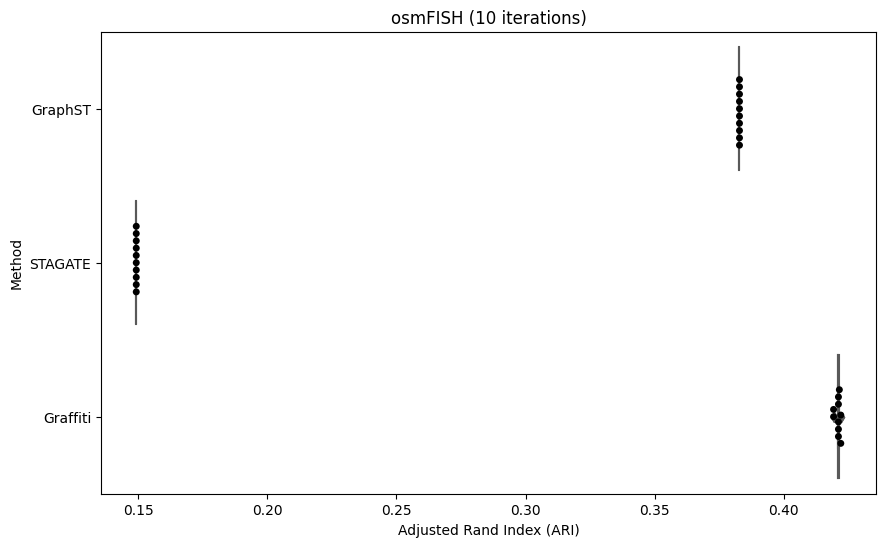

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)

# Customizing the plot
plt.xlabel('Adjusted Rand Index (ARI)')
plt.ylabel('Method')
plt.title('osmFISH (10 iterations)')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GRAFITI v.s. GRAFITICL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.671e-04 U_stat=0.000e+00
GRAFITICL v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.257e-04 U_stat=1.000e+02
STAGATE v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.563e-05 U_stat=0.000e+00
GRAFITI v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.000e+01
GRAFITICL v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.257e-04 U_stat=1.000e+02
GRAFITI v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.832e-04 U_stat=0.000e+00


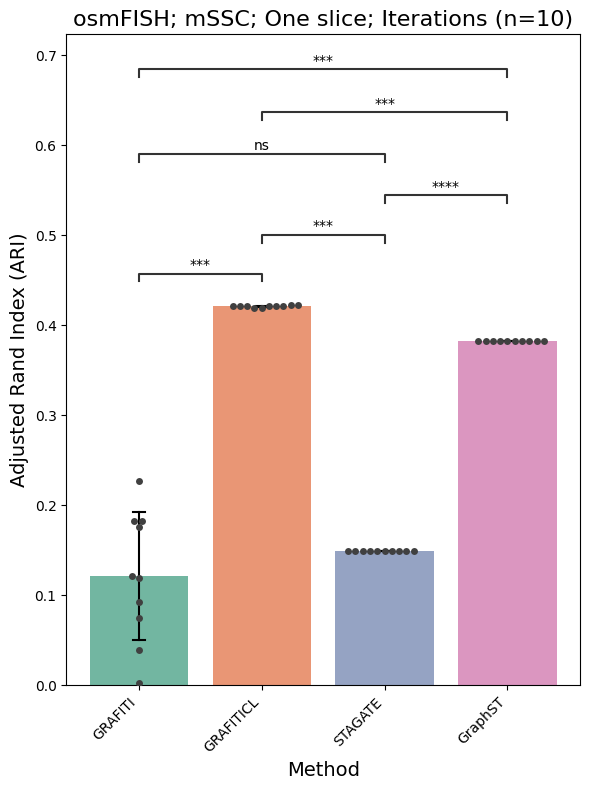

In [35]:
create_comparison_plot([og_grafiti,grafiti,stagate,graphst], ['GRAFITI','GRAFITICL','STAGATE','GraphST'], [0,1,2,3], 'barplot', 'osmFISH; mSSC; One slice; Iterations (n=10)', figsize=(6,8), save=f'{figdir}/boxplot.pdf')

In [34]:
import numpy as np
np.median(list(grafiti.values()))/np.median(list(og_grafiti[0].values()))

3.4957017691467107

In [24]:
list_dic=[
    read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_v3.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_norm.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v3.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_5_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_100_100_0.0001_10_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_5_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_grid_100_100_0.0001_10_5_0.995.h5ad'),
]

categories=[
    'Original',
    'Early Stopping',
    'Original with Adam Optimizer',
    'Contrastive Learning DGI',
    'Contrastive Learning DGI Normalized',
    'Contrastive Learning DGI with Adam Optimizer [5,5]',
    'Contrastive Learning DGI with Adam Optimizer [10,1]',
    'Contrastive Learning DGI Local Read Generic [10,1] - y=.995',
    'Contrastive Learning DGI Local Read Generic [10,1] - y=1',
    'Contrastive Learning DGI Local Read Generic [5,5] - y=.995',
    'Contrastive Learning DGI Local Read Generic [5,5] - y=1',
    'Contrastive Learning DGI Local Read Generic [1,10] - y=.995',
    'Contrastive Learning DGI Local Read Generic [1,10] - y=1',
    'Contrastive Learning DGI Local Read Generic [5,10] - y=.995',
    'Contrastive Learning DGI Local Read Generic [10,5] - y=.995',
    'Contrastive Learning DGI Local Read Grid [10,1] - y=.995',
    'Contrastive Learning DGI Local Read Grid [5,5] - y=.995',
    'Contrastive Learning DGI Local Read Grid [1,10] - y=.995',
    'Contrastive Learning DGI Local Read Grid [5,10] - y=.995',
    'Contrastive Learning DGI Local Read Grid [10,5] - y=.995',

]

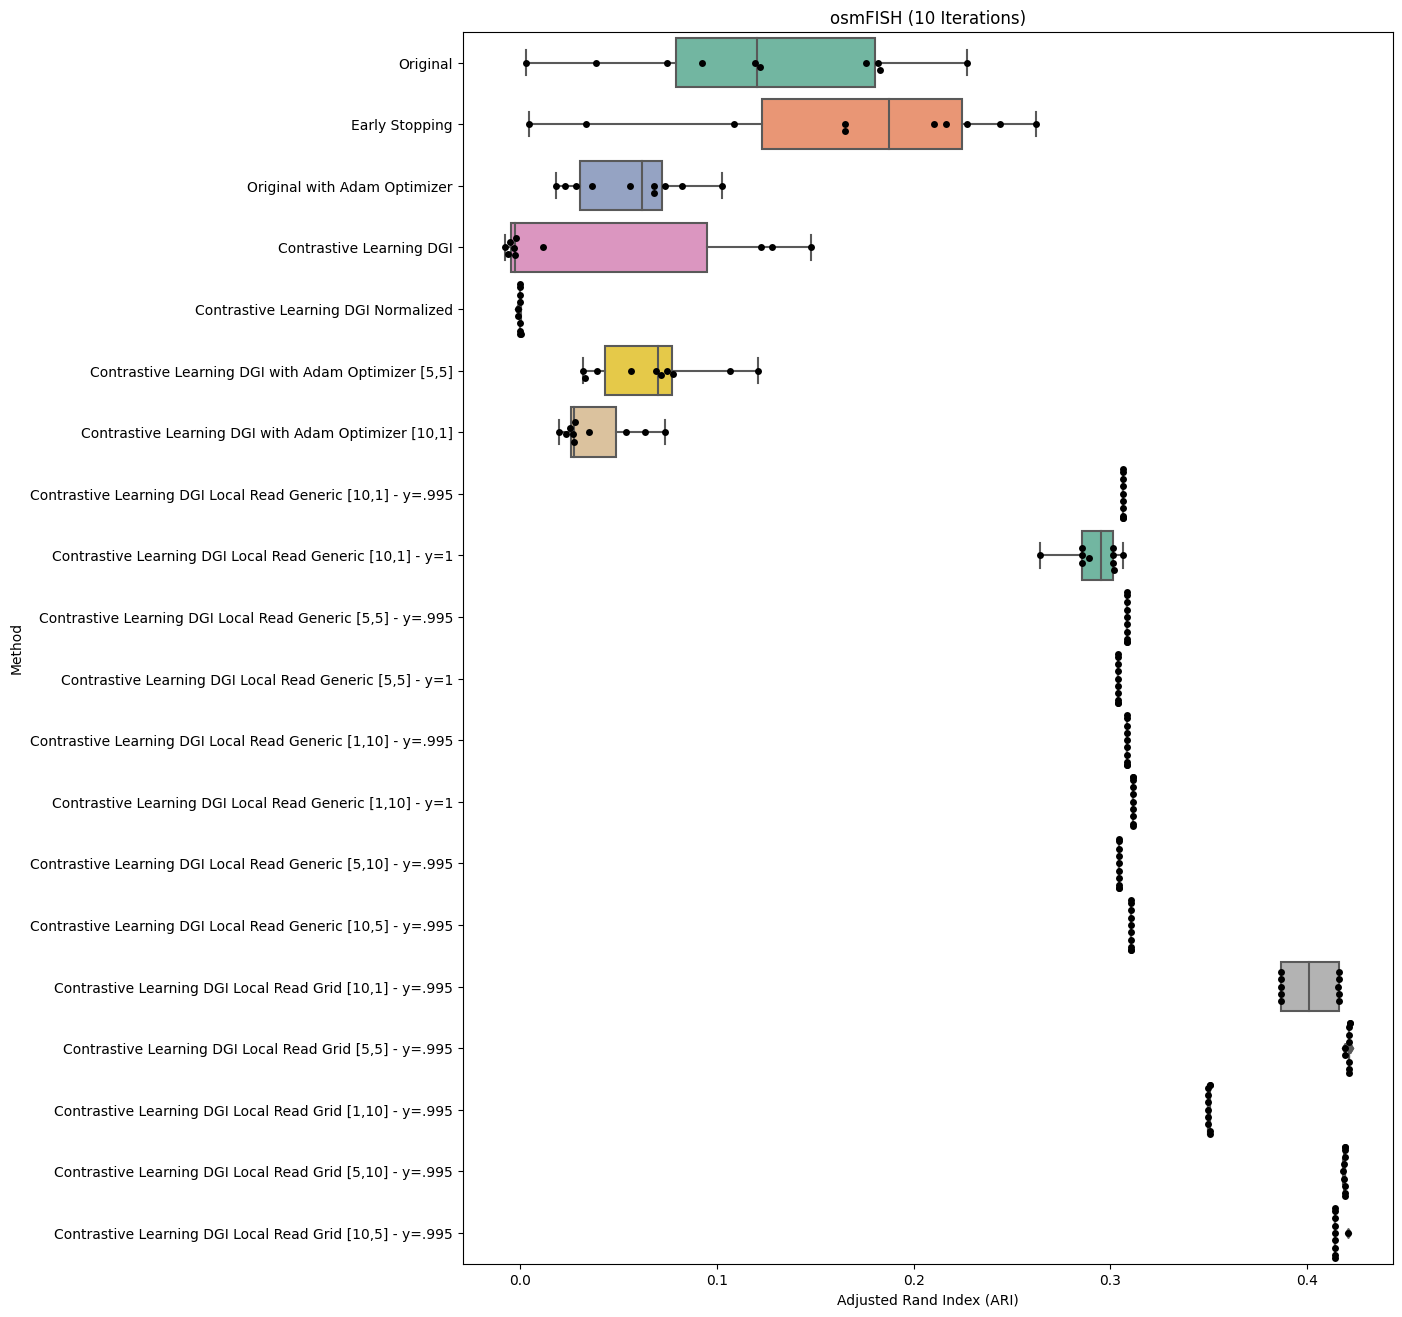

In [25]:
plot_boxplot(list_dic[:],categories[:])

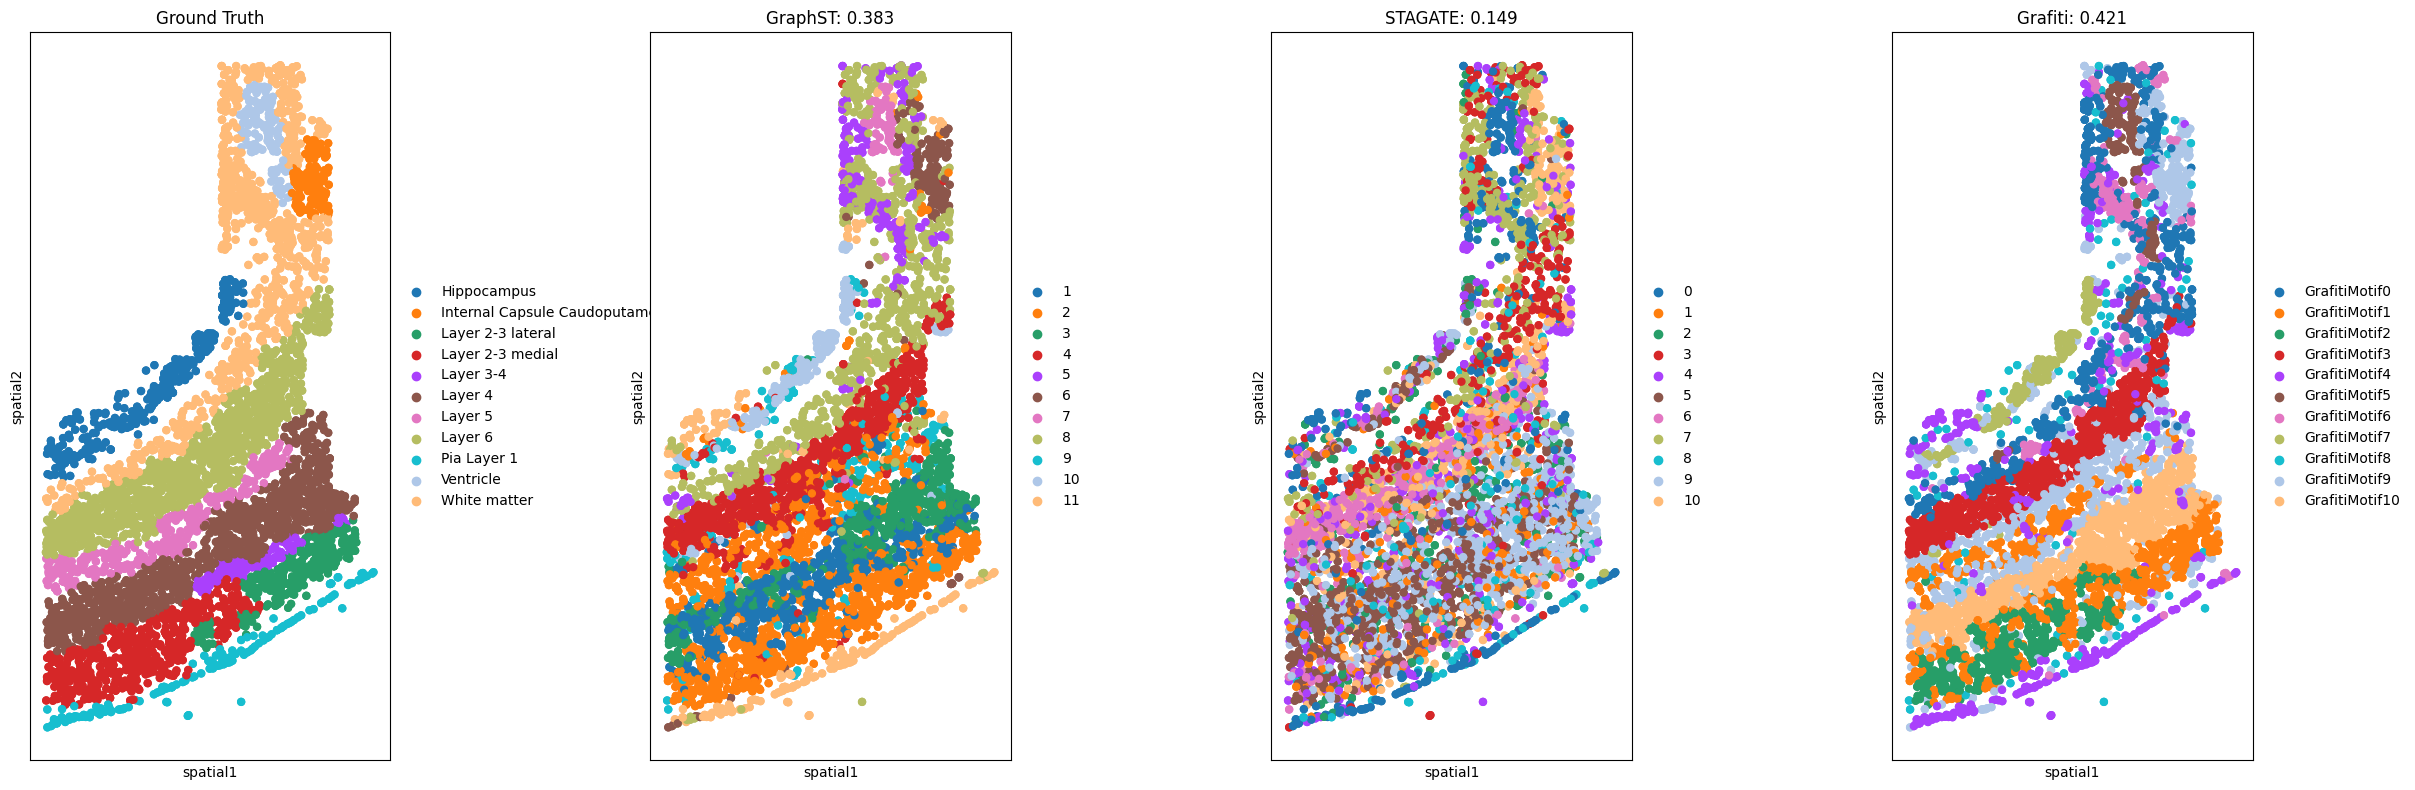

In [54]:
plot_spatial(datadir, 9)

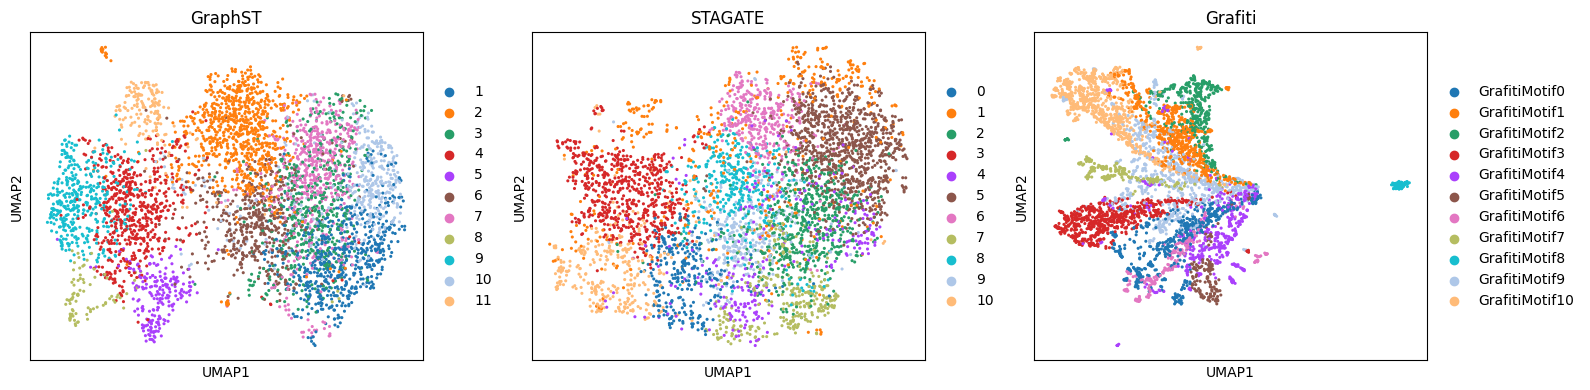

In [58]:
plot_umap(datadir, 2)

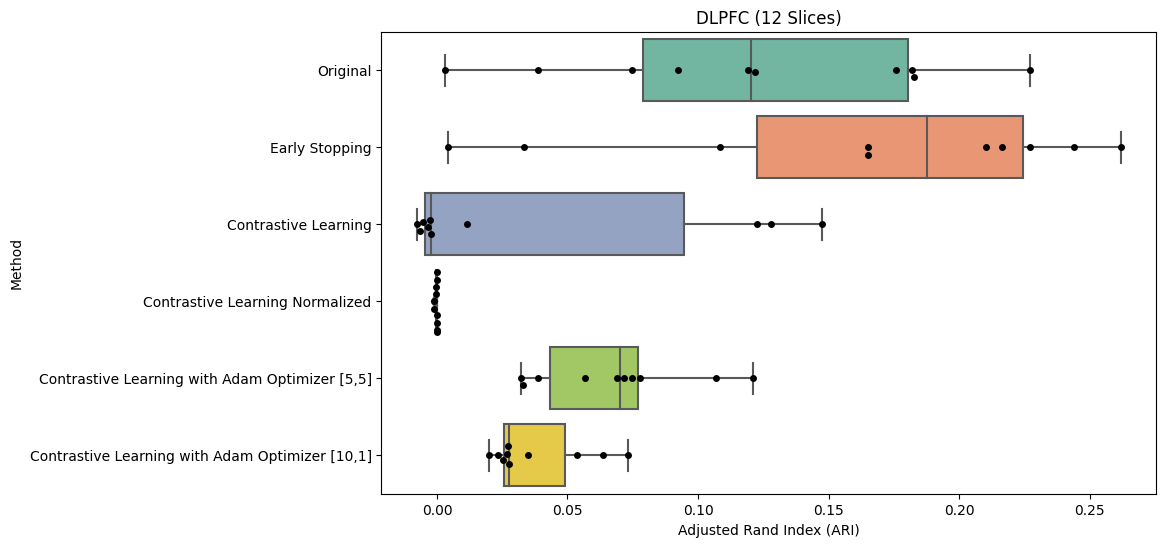

In [18]:
list_dic = [
    read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_norm.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v3.pkl')
]
categories = [
    'Original',
    'Early Stopping',
    'Contrastive Learning',
    'Contrastive Learning Normalized',
    'Contrastive Learning with Adam Optimizer [5,5]',
    'Contrastive Learning with Adam Optimizer [10,1]'
]
plot_boxplot(list_dic,categories)

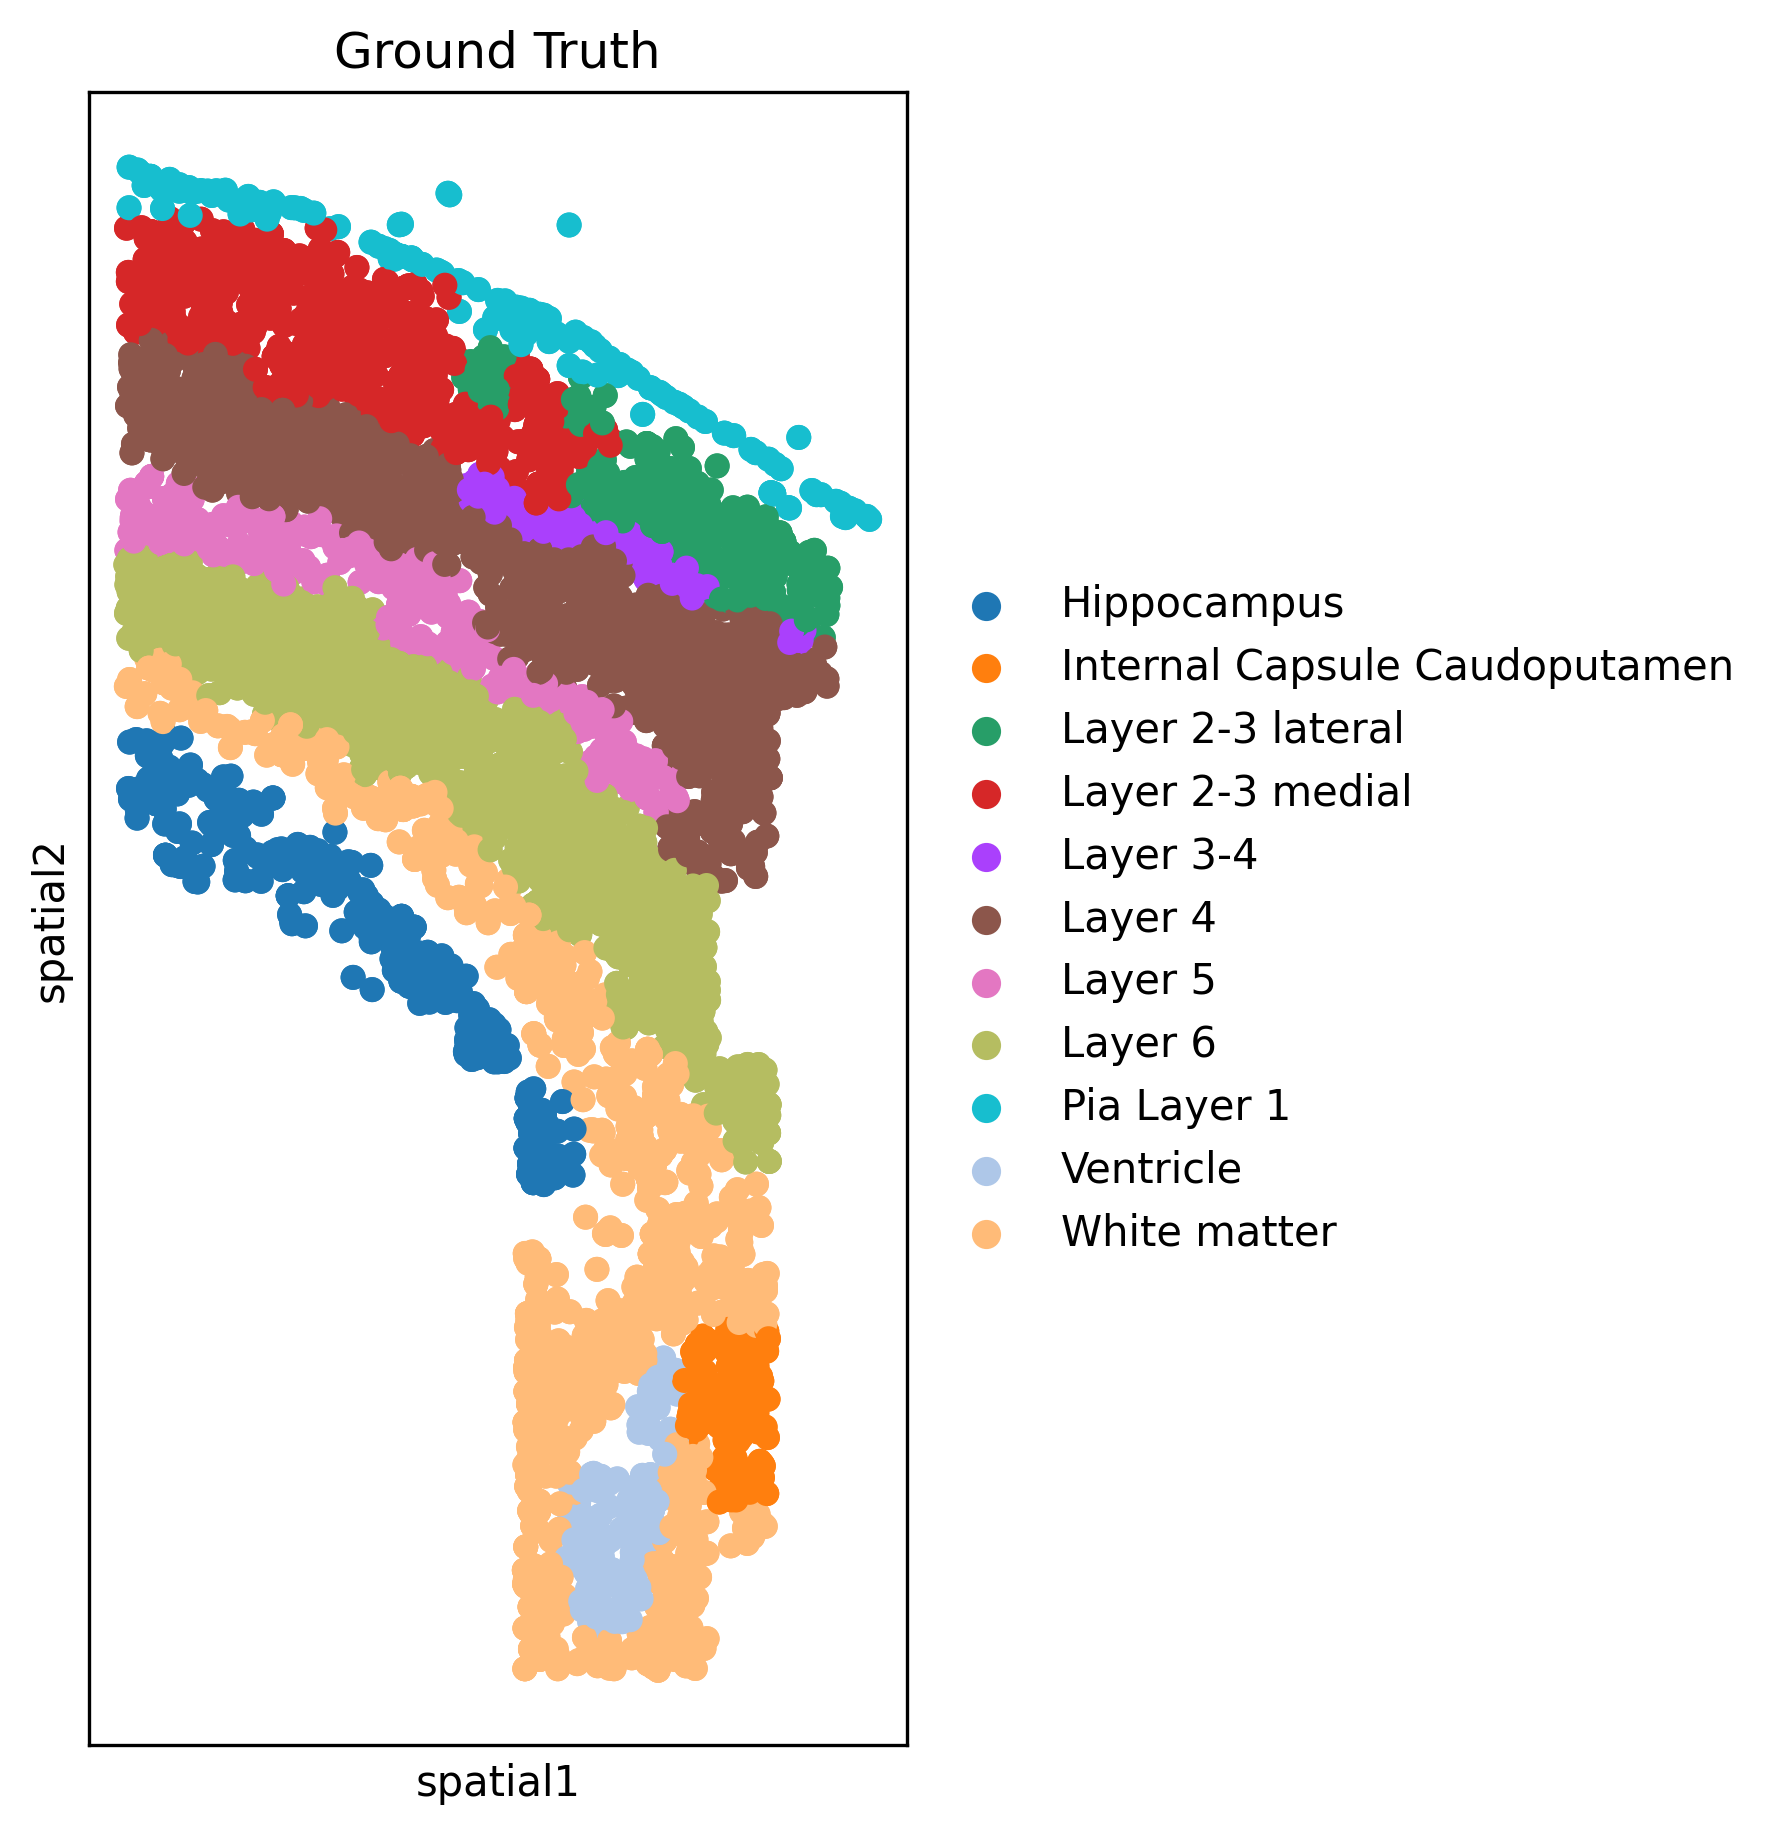

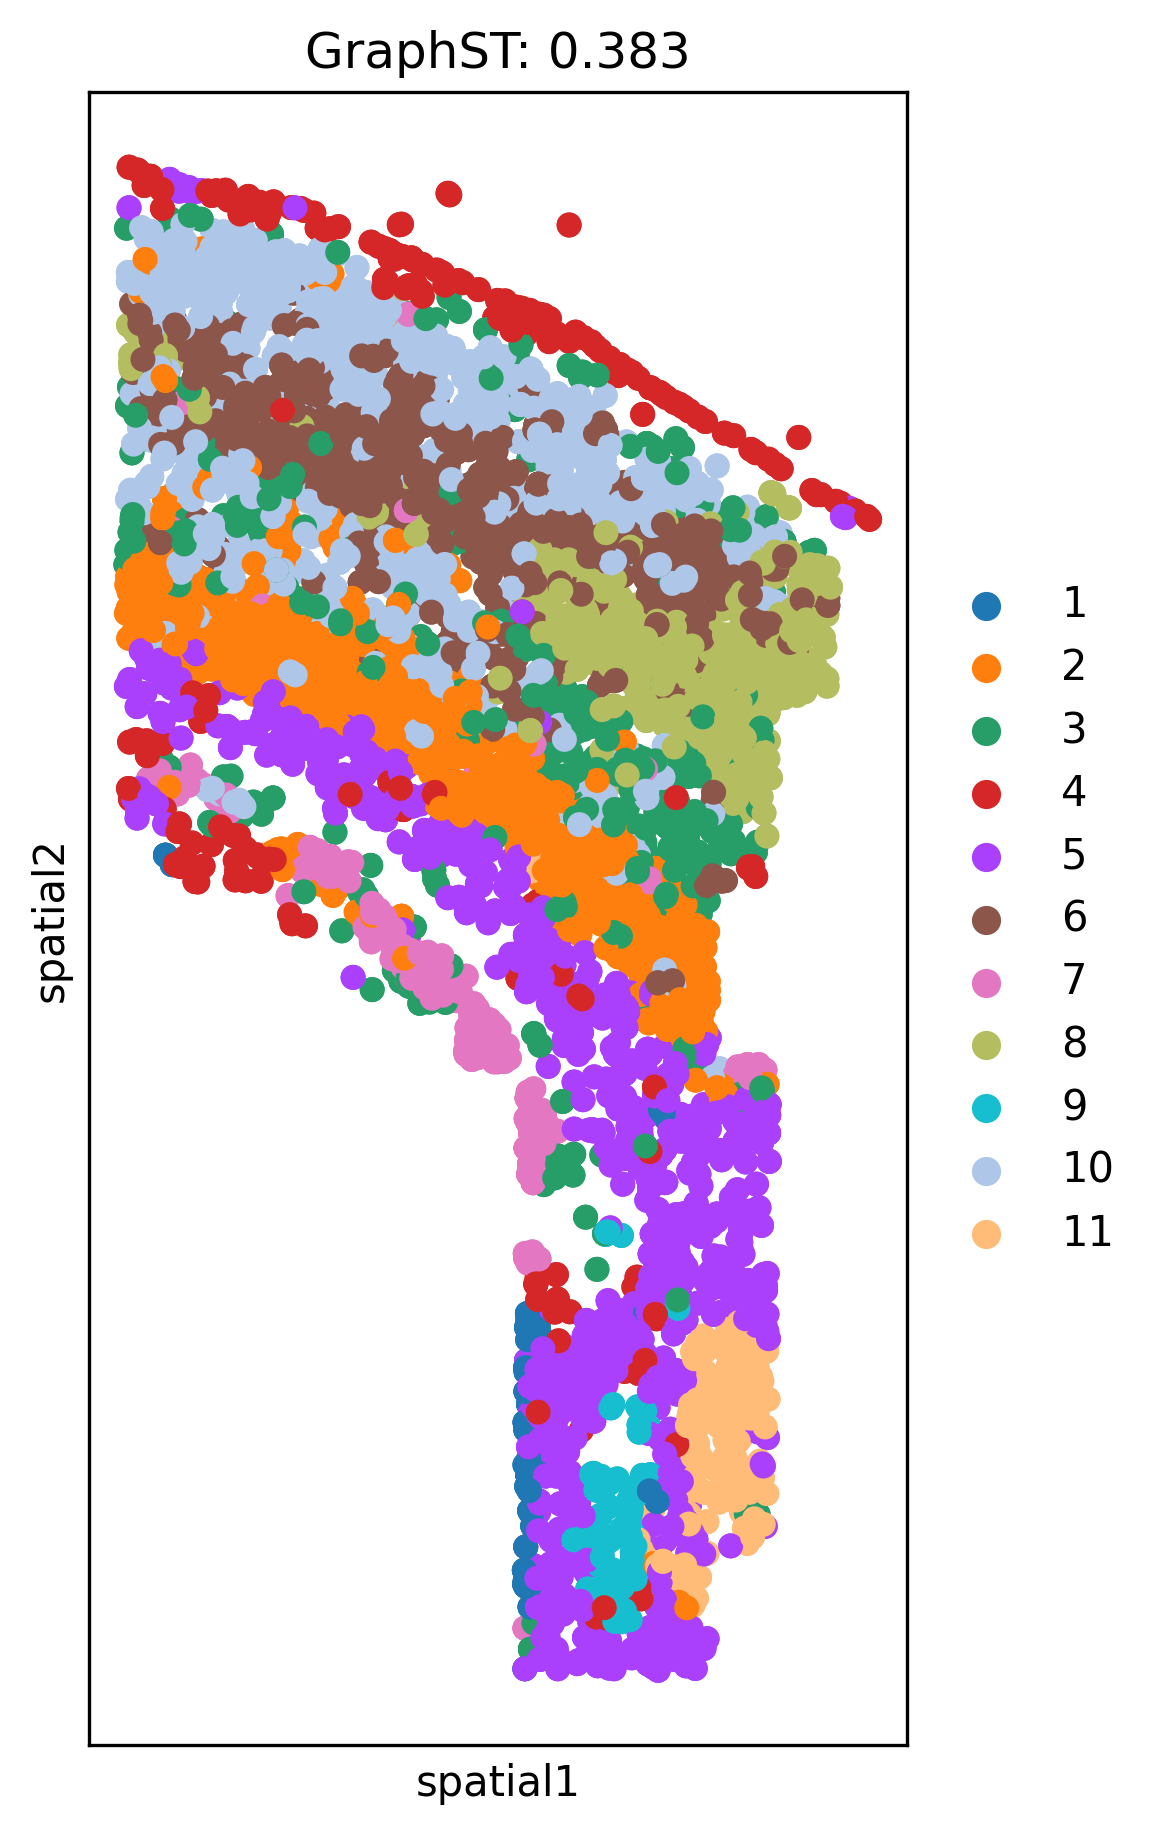

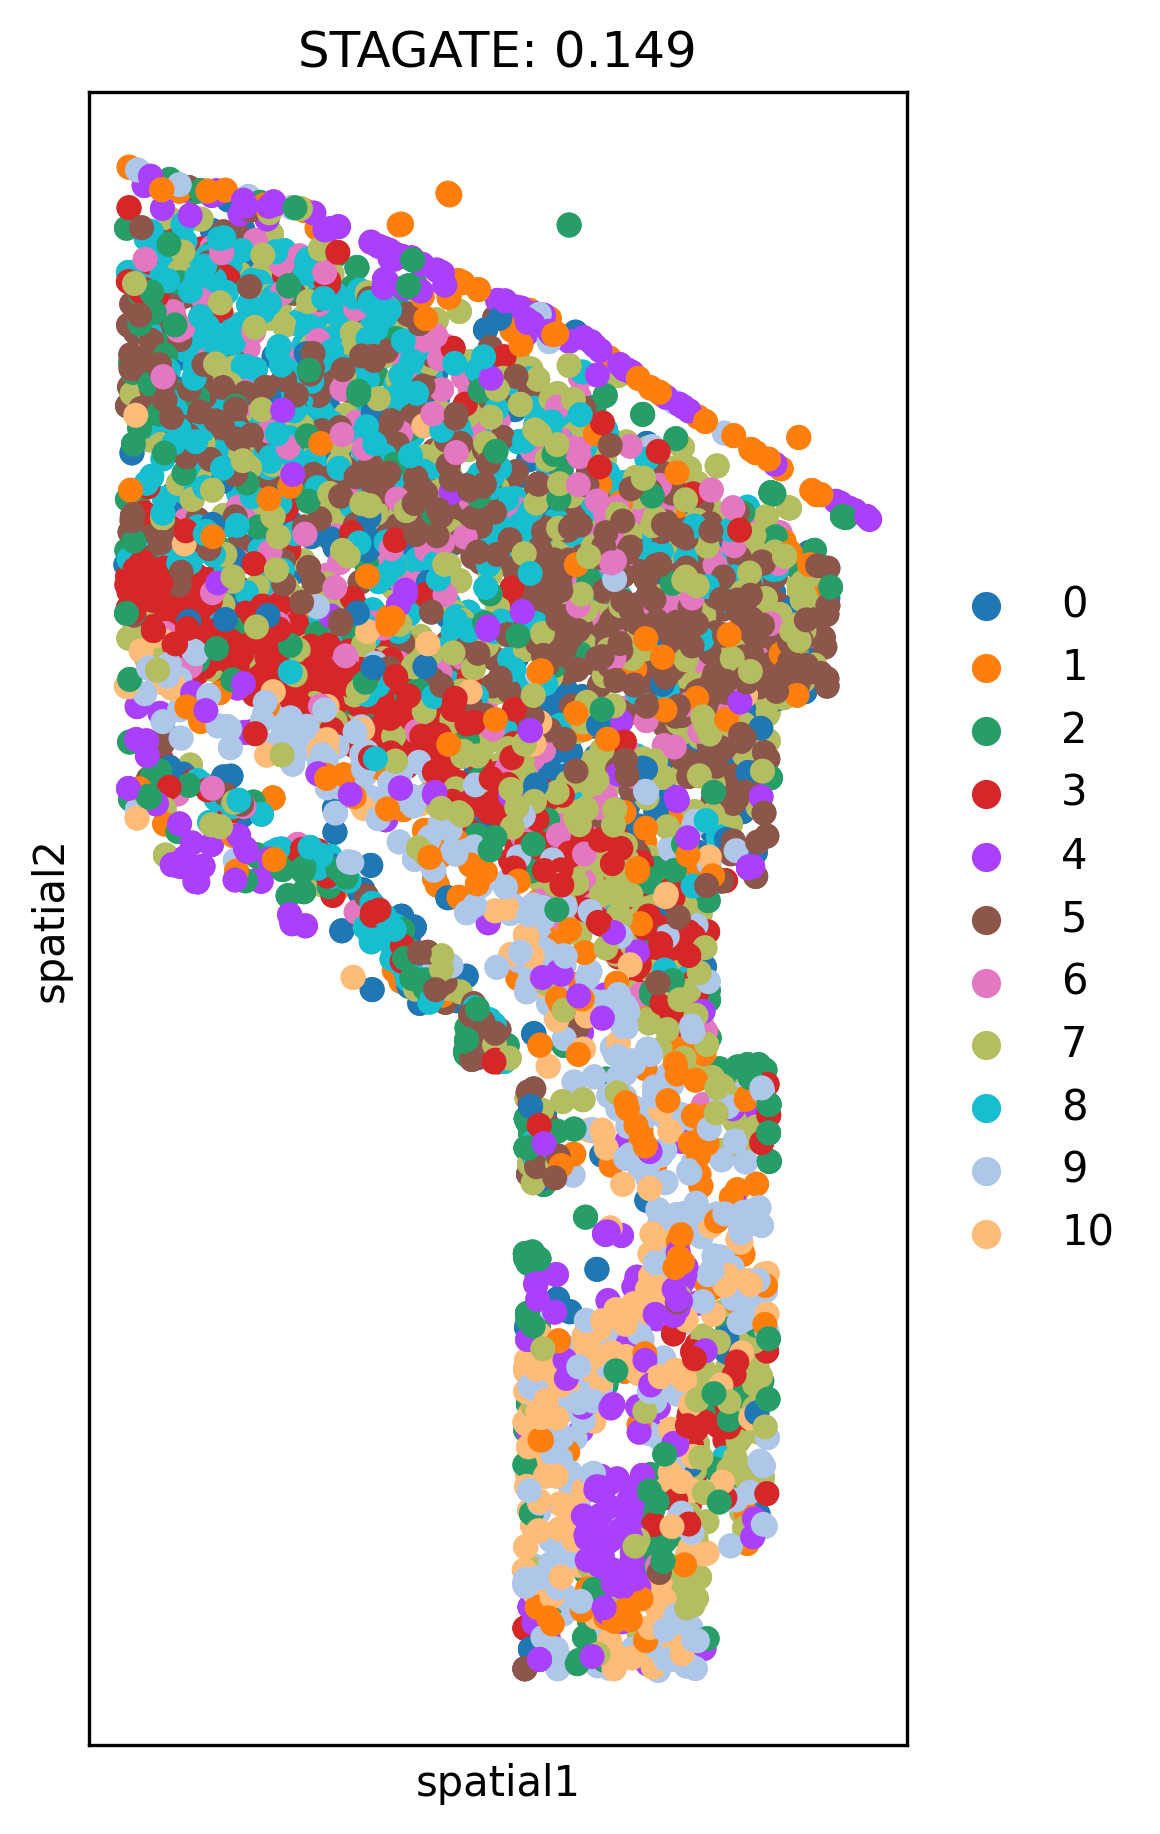

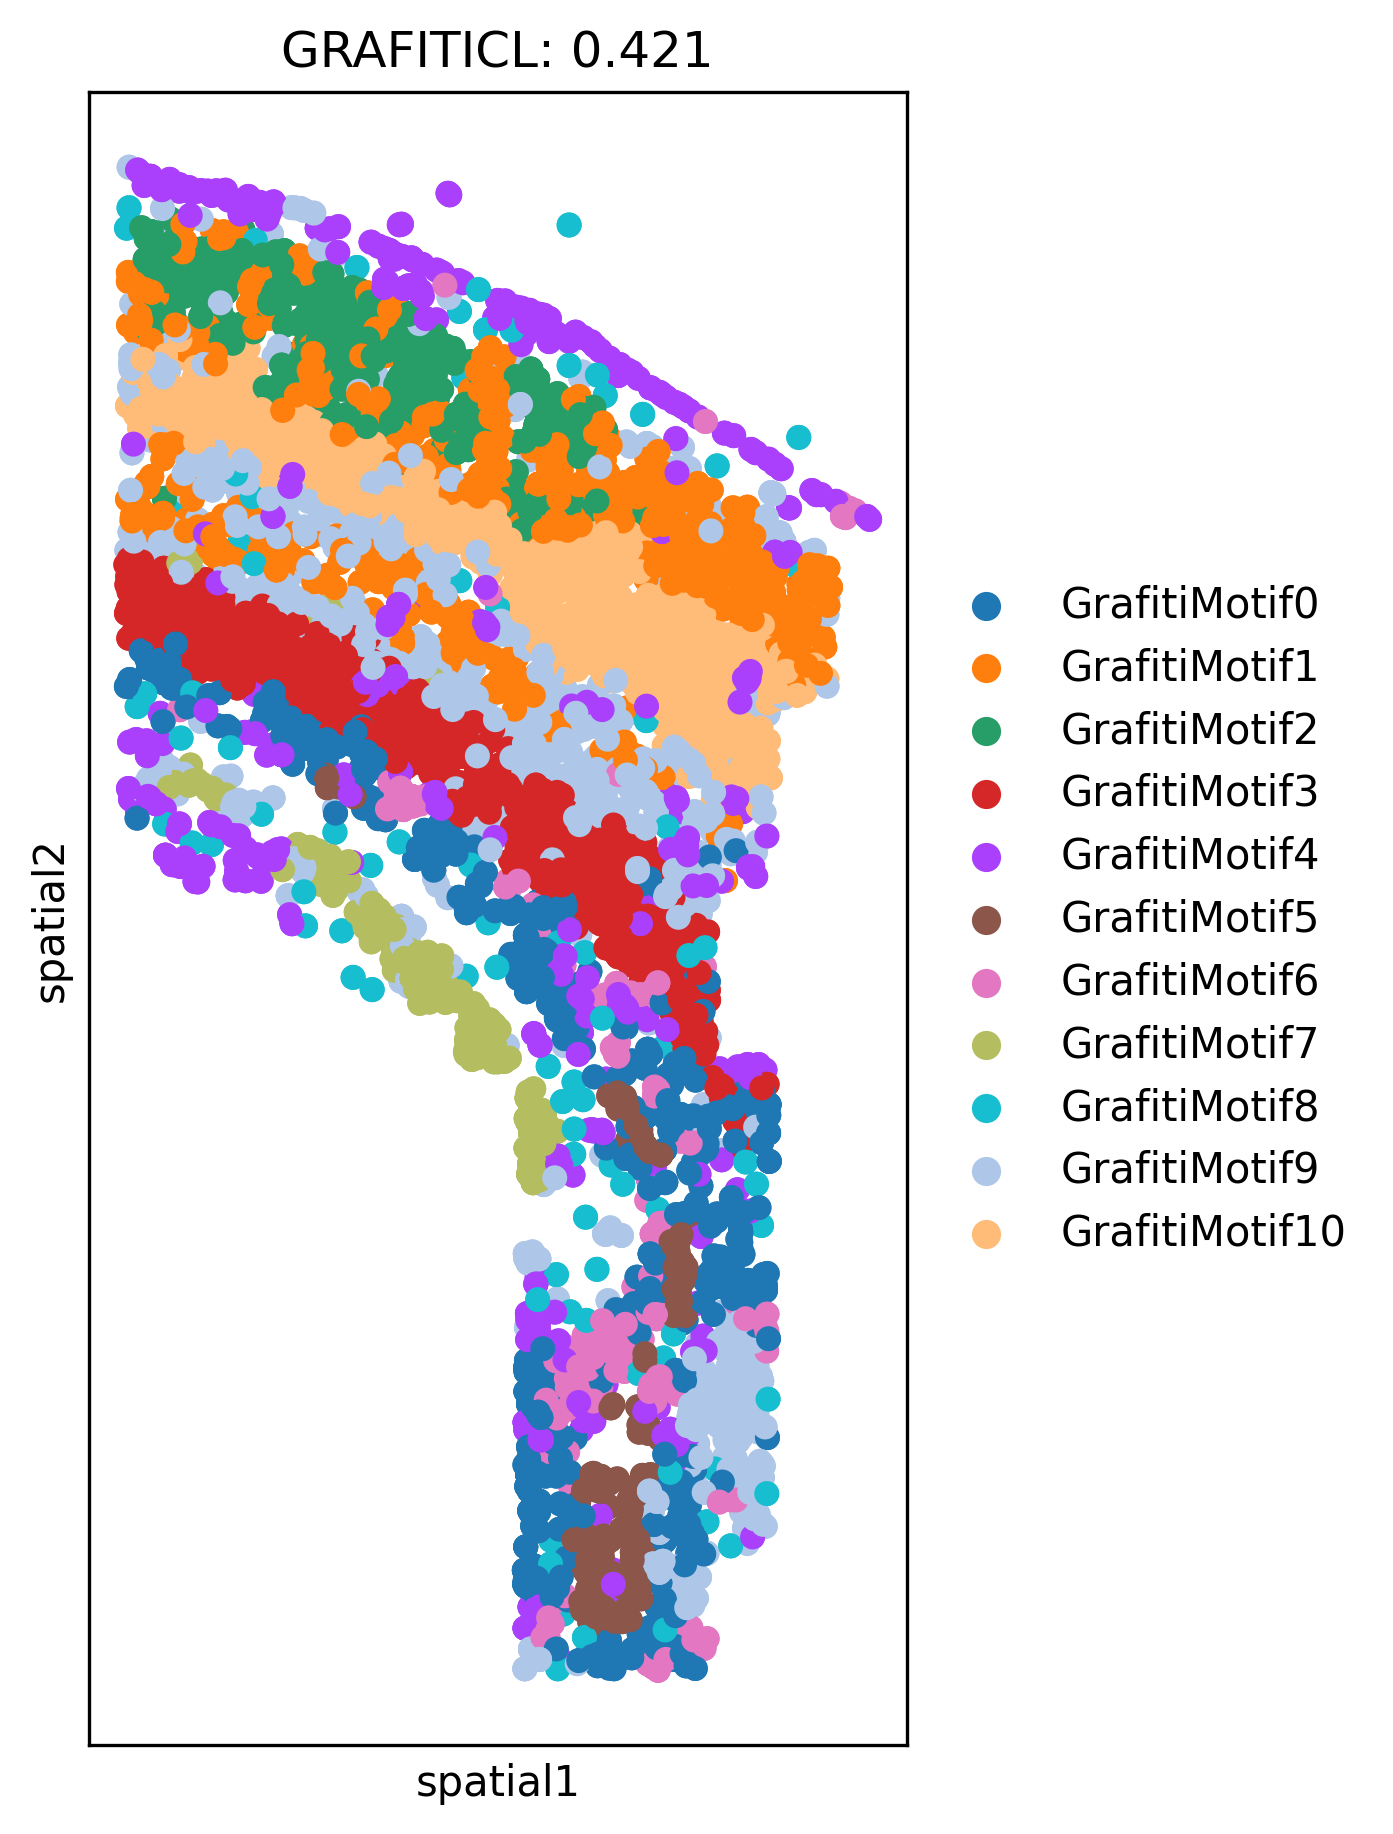

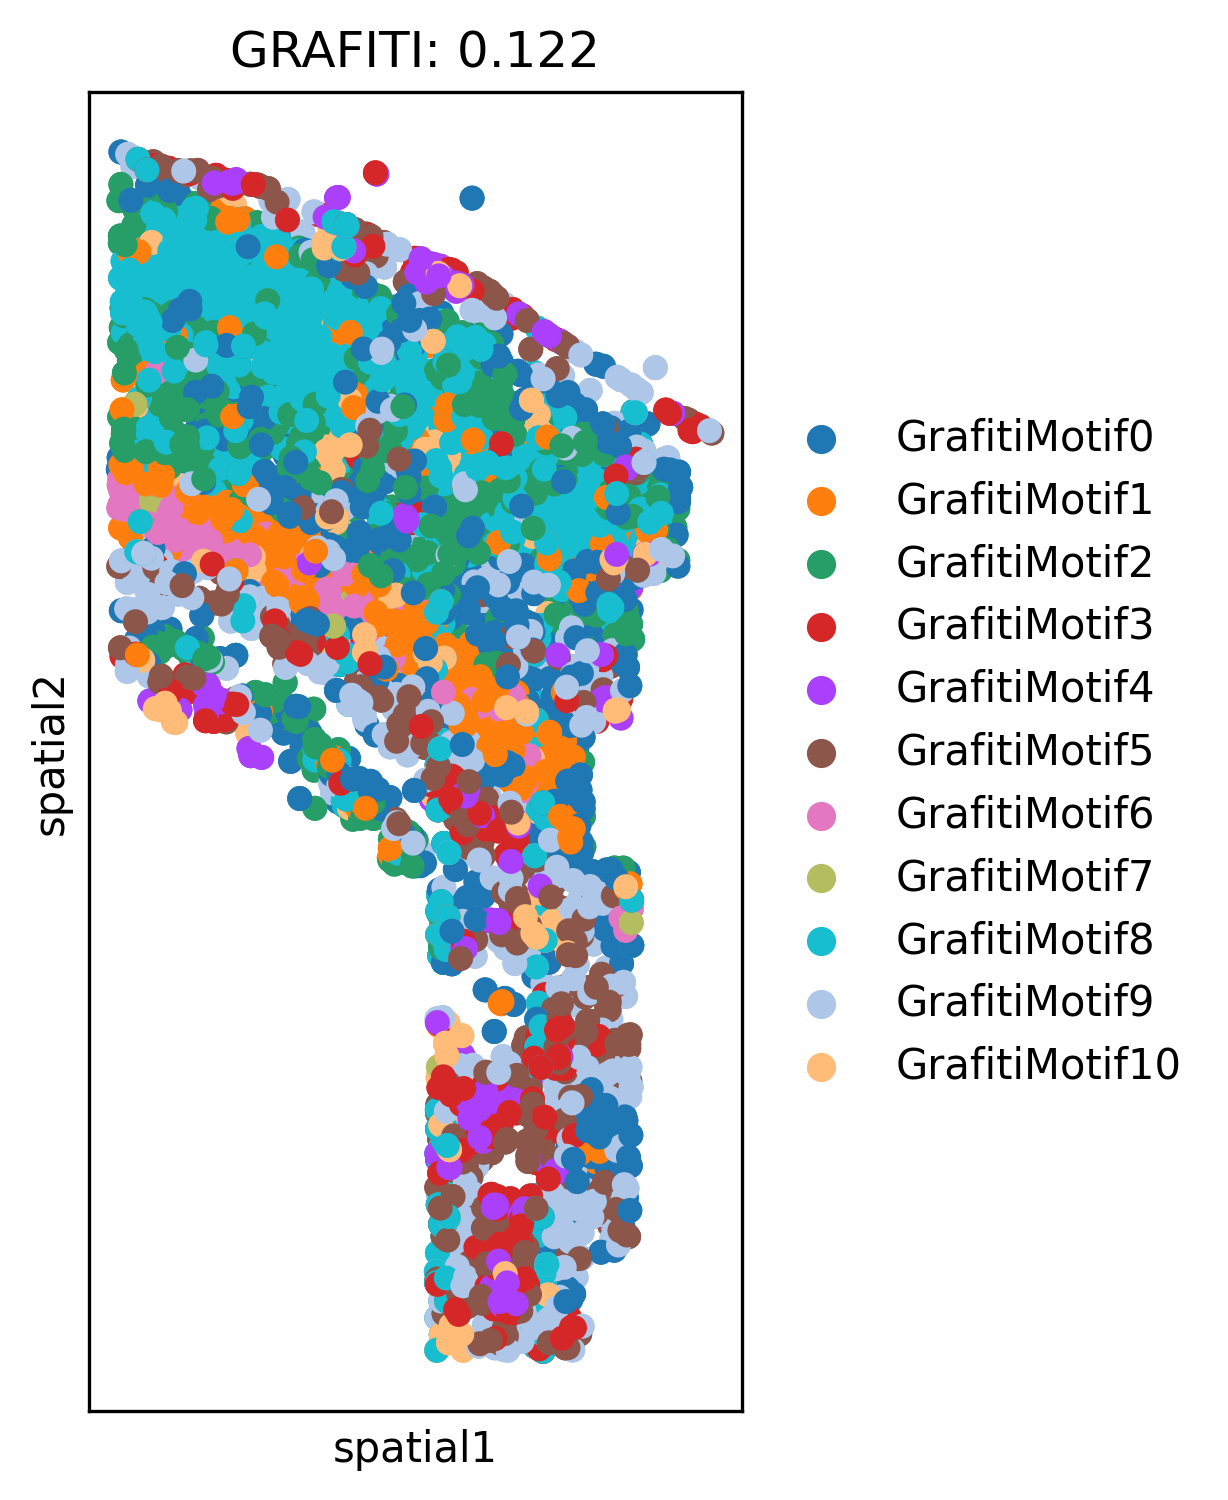

In [65]:
iteration=3
save = f'{figdir}/{iteration}_spatial_scatter'
figsize=(20,6)
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst_s_{iteration}.h5ad')
adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate_s_{iteration}.h5ad')
adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{iteration}_grafiti_lodcl_grid_100_100_0.0001_5_5_0.995.h5adf')
adata_og_grafiti = sc.read_h5ad(f'{datadir}/grafiti/osmfish_grafiti_{iteration}.h5ad')

adata_graphst.obsm['spatial'][:, 1] = -adata_graphst.obsm['spatial'][:, 1]
adata_stagate.obsm['spatial'][:, 1] = -adata_stagate.obsm['spatial'][:, 1]
adata_grafiti.obsm['spatial'][:, 1] = -adata_grafiti.obsm['spatial'][:, 1]
adata_og_grafiti.obsm['spatial'][:, 1] = -adata_og_grafiti.obsm['spatial'][:, 1]
adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')

sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape=None, size=100, figsize=figsize, dpi=300, save=f'{save}_gt.pdf')
sq.pl.spatial_scatter(adata_graphst, title = 'GraphST: %.3f'%(graphst[iteration]), color ='mclust', shape=None, size=100, figsize=figsize, dpi=300,save=f'{save}_graphst.pdf')
sq.pl.spatial_scatter(adata_stagate, title = 'STAGATE: %.3f'%(stagate[iteration]), color ='mclust', shape=None, size=100, figsize=figsize, dpi=300,save=f'{save}_stagate.pdf')
sq.pl.spatial_scatter(adata_grafiti, title = 'GRAFITICL: %.3f'%(grafiti[iteration]), color ='grafiti_motif', shape=None, size=100, figsize=figsize, dpi=300,save=f'{save}_grafiti.pdf')
sq.pl.spatial_scatter(adata_og_grafiti, title = 'GRAFITI: %.3f'%(og_grafiti[0][iteration]), color ='grafiti_motif', shape=None, size=100, figsize=figsize, dpi=300,save=f'{save}_og_grafiti.pdf')
plt.tight_layout() 
#if save != None:b

# fig.savefig(save, dpi=300, bbox_inches='tight')
plt.show()

In [47]:
adata_graphst.obsm['spatial'][1]

array([19838.08  ,  6456.1445], dtype=float32)

In [8]:
distribution = read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2_distribution.pkl')
distribution_s = read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2_distribution_s.pkl')

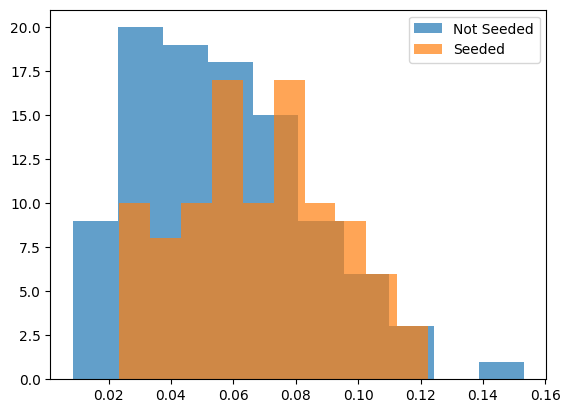

In [10]:
plt.hist(distribution.values(), label="Not Seeded", alpha=.7)
plt.hist(distribution_s.values(), label="Seeded", alpha=.7)
plt.legend()
plt.show()

# GRAFITI

In [68]:
adata = sc.read_h5ad(f'{datadir}/raw/osmfish_remove_excluded.h5ad')
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [69]:
sq.gr.spatial_neighbors(adata,radius=50,coord_type='generic',delaunay=True) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [390]:
gae = gf.ml.GAE(adata, layers=[100,20], lr=0.01, device=device, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [391]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 109919568.0
Epoch 100 ** iteration 100 ** Loss: 61749305.76
Epoch 200 ** iteration 200 ** Loss: 9604123.40390625
Epoch 300 ** iteration 300 ** Loss: 110077.553125
Epoch 400 ** iteration 400 ** Loss: 96945.90375
Epoch 500 ** iteration 500 ** Loss: 96473.983671875
Early stopping due to no improvement over 10 epochs.
Training Complete.


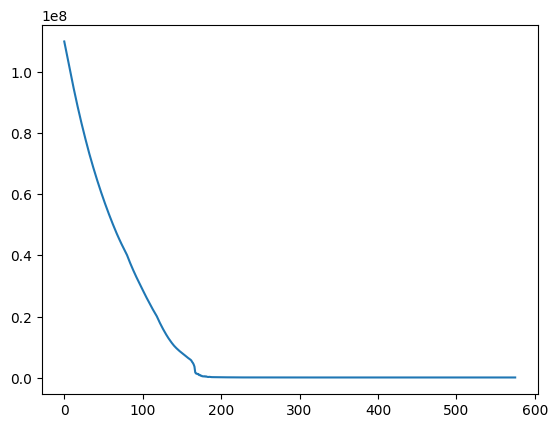

In [392]:
gae.plot()

In [393]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [394]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [395]:
gf.tl.find_motifs_gmm(adata,k=11)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=11, random_state=0,
                verbose=True)

# Leiden

In [323]:
#adata_leiden = adata.copy()

In [203]:
#n_clusters=11    #according own dataset

In [204]:
#sc.tl.pca(adata_leiden, n_comps=50, svd_solver='arpack')
#sc.pp.neighbors(adata_leiden, n_neighbors=100, n_pcs=50) # 20
#eval_resolution = 2
#sc.tl.leiden(adata_leiden, key_added="leiden", resolution=eval_resolution)

In [205]:
#sc.pl.embedding(adata_leiden, basis='spatial', color ='leiden', s=20, add_outline=True)

# GraphST

In [206]:
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst.h5ad')

In [207]:
adata.obs['graphst'] = adata_graphst.obs['domain']

In [208]:
adata_graphst

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ClusterName_colors', 'Region_colors', 'domain_colors', 'hvg', 'log1p'
    obsm: 'adj', 'distance_matrix', 'emb', 'emb_pca', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'

In [209]:
umap(adata_graphst, encoding_key="emb")

# STAGATE

In [210]:
adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate.h5ad')

In [211]:
adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')

In [212]:
adata.obs['stagate'] = adata_stagate.obs['mclust']

In [213]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'grafiti_motif', 'GrafitiMotif0_proba', 'GrafitiMotif1_proba', 'GrafitiMotif10_proba', 'GrafitiMotif2_proba', 'GrafitiMotif3_proba', 'GrafitiMotif4_proba', 'GrafitiMotif5_proba', 'GrafitiMotif6_proba', 'GrafitiMotif7_proba', 'GrafitiMotif8_proba', 'GrafitiMotif9_proba', 'graphst', 'stagate'
    uns: 'ClusterName_colors', 'spatial_neighbors', 'grafiti_motif_proba', 'Region_colors', 'graphst_colors', 'stagate_colors', 'grafiti_motif_colors'
    obsm: 'spatial', 'X_grafiti', 'X_umap'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Plots

In [396]:
# calculate metric ARI
graphst_ari = metrics.adjusted_rand_score(adata.obs['graphst'], adata.obs['Region'])
stagate_ari = metrics.adjusted_rand_score(adata.obs['stagate'], adata.obs['Region'])
grafiti_ari = metrics.adjusted_rand_score(adata.obs['grafiti_motif'], adata.obs['Region'])

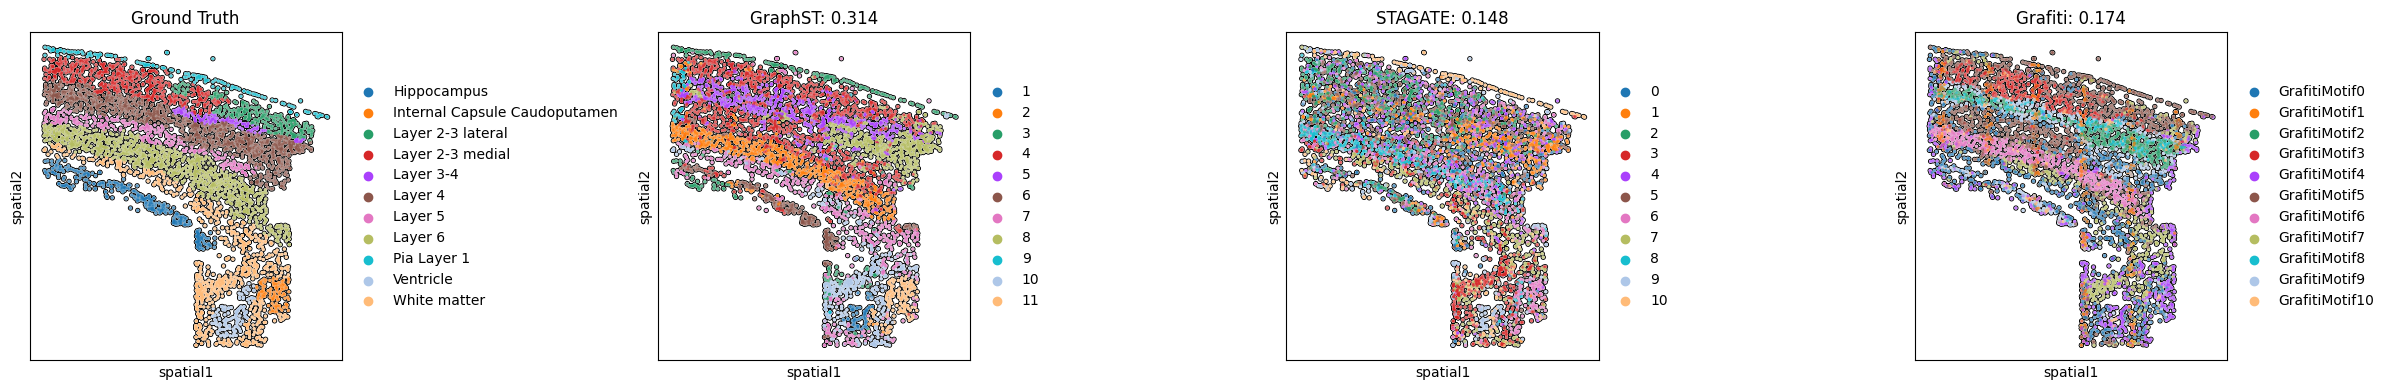

<Figure size 640x480 with 0 Axes>

In [397]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
sc.pl.embedding(adata, basis='spatial', title = 'Ground Truth', color='Region', ax=axes[0], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'GraphST: %.3f'%(graphst_ari), color ='graphst', ax=axes[1], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'STAGATE: %.3f'%(stagate_ari), color ='stagate', ax=axes[2], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(grafiti_ari), color ='grafiti_motif', ax=axes[3], s=20, add_outline=True, show=False)
plt.tight_layout()
plt.show()
plt.savefig(f'{figdir}/osmfish_spatial.png', bbox_inches="tight")

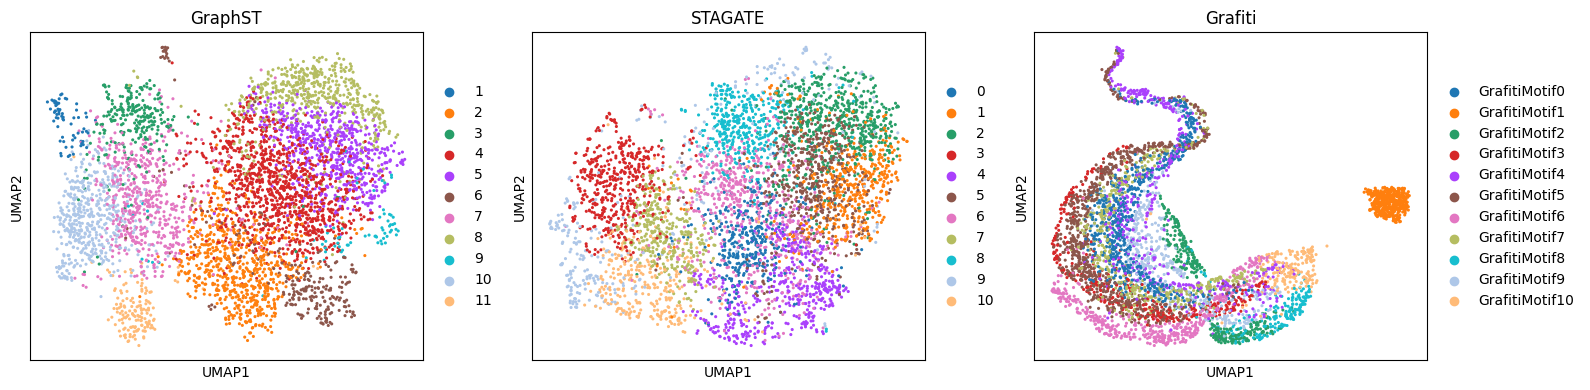

<Figure size 640x480 with 0 Axes>

In [398]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sc.pl.umap(adata_graphst,title="GraphST",color=["domain"],ax=axes[0],s=20,show=False)
sc.pl.umap(adata_stagate,title="STAGATE",color=["mclust"],ax=axes[1],s=20,show=False)
sc.pl.umap(adata,title="Grafiti",color=["grafiti_motif"],ax=axes[2],s=20,show=False)
plt.tight_layout()
plt.show()
plt.savefig(f'{figdir}/osmfish_umap.png', bbox_inches="tight")

In [226]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'grafiti_motif', 'GrafitiMotif0_proba', 'GrafitiMotif1_proba', 'GrafitiMotif10_proba', 'GrafitiMotif2_proba', 'GrafitiMotif3_proba', 'GrafitiMotif4_proba', 'GrafitiMotif5_proba', 'GrafitiMotif6_proba', 'GrafitiMotif7_proba', 'GrafitiMotif8_proba', 'GrafitiMotif9_proba', 'graphst', 'stagate'
    uns: 'ClusterName_colors', 'spatial_neighbors', 'grafiti_motif_proba', 'Region_colors', 'graphst_colors', 'stagate_colors', 'grafiti_motif_colors'
    obsm: 'spatial', 'X_grafiti', 'X_umap'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Distribution Testing

In [4]:
plot_data = adata.to_df()
features = ['Gad2', 'Slc32a1', 'Crhbp', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',
       'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 'Kcnip2', 'Aldoc', 'Gfap', 'Serpinf1',
       'Mfge8', 'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2', 'Ctps',
       'Anln', 'Mrc1', 'Hexb', 'Ttr', 'Foxj1', 'Vtn', 'Flt1', 'Apln', 'Acta2']

/tmp/ipykernel_3351785/3580000630.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


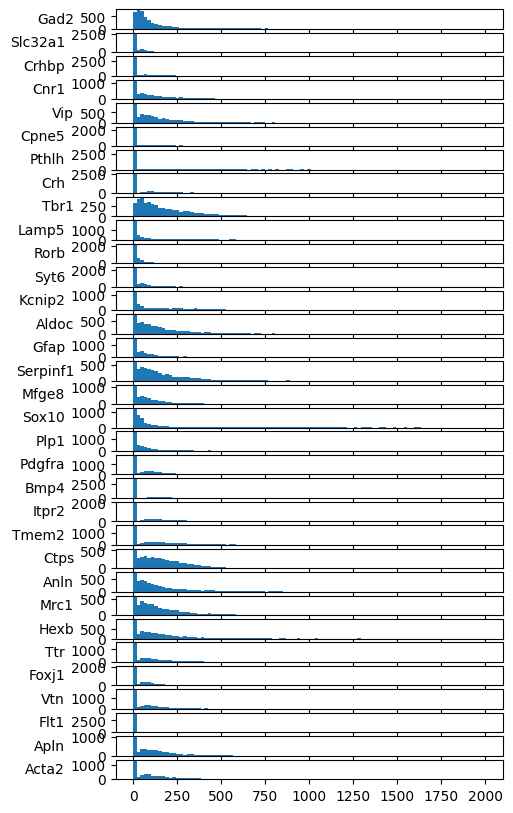

In [5]:
fig, axes = plt.subplots(nrows=len(features), figsize=(5, 10))

for f, ax in zip(features, axes):
    #ax.set_xscale('log')
    ax.hist(plot_data[f], bins=np.linspace(0,2000,100))#, bins=np.logspace(np.log10(1.0), np.log10(10000.0), 50))
    ax.set_ylabel(f, rotation=0, ha='right', va='center')

plt.tight_layout()